<a href="https://colab.research.google.com/github/MicroPyscho/Credit-Card-Fraud-Prediction-using-GAN/blob/main/SVR_XGB.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!pip install tensorflow
!pip install tensorflow_addons
!pip install ranger-adabelief

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 611.8/611.8 kB 4.8 MB/s eta 0:00:00
  Using cached nvidia_cuda_nvrtc_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (23.7 MB)
  Using cached nvidia_cuda_runtime_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (823 kB)
  Using cached nvidia_cuda_cupti_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (14.1 MB)
  Using cached nvidia_cudnn_cu12-8.9.2.26-py3-none-manylinux1_x86_64.whl (731.7 MB)
  Using cached nvidia_cublas_cu12-12.1.3.1-py3-none-manylinux1_x86_64.whl (410.6 MB)
  Using cached nvidia_cufft_cu12-11.0.2.54-py3-none-manylinux1_x86_64.whl (121.6 MB)
  Using cached nvidia_curand_cu12-10.3.2.106-py3-none-manylinux1_x86_64.whl (56.5 MB)
  Using cached nvidia_cusolver_cu12-11.4.5.107-py3-none-manylinux1_x86_64.whl (124.2 MB)
  Using cached nvidia_cusparse_cu12-12.1.0.106-py3-none-manylinux1_x86_64.whl (196.0 MB)
  Using cached nvidia_nccl_cu12-2.20.5-py3-none-manylinux2014_x86_64.whl (176.2 MB)
  Using cached nvidia_nvtx_cu12-12.1.105-py3-none-m

In [2]:
import tensorflow as tf
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import torch
from google.colab import drive
from tensorflow import keras
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.neural_network import MLPRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import accuracy_score
from sklearn.preprocessing import PowerTransformer
from sklearn.metrics import classification_report
from sklearn.neighbors import KNeighborsClassifier
import seaborn as sns
from sklearn.svm import SVR
import xgboost as xgb
from sklearn.model_selection import GridSearchCV
from sklearn.neighbors import KNeighborsRegressor
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import RandomForestRegressor
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout
from tensorflow.keras import regularizers
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping
from sklearn.neighbors import KNeighborsRegressor
from sklearn.metrics import mean_squared_error
from torch import nn

In [4]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [5]:
int_cols = pd.read_csv("/content/drive/MyDrive/int_cols.csv")

In [6]:
scaler = StandardScaler()
int_cols_scaled = pd.DataFrame(scaler.fit_transform(int_cols), columns=int_cols.columns)

#Apply log transformation if necessary
#Assuming the target column is 'total_emissns', let's check for skewness
target_col = 'total_emissns'
if np.abs(int_cols_scaled[target_col].skew()) > 0.5:
    int_cols_scaled[target_col] = np.log1p(int_cols_scaled[target_col])

# Split the data into features and target
X = int_cols_scaled.drop(columns=["total_emissns", "Emission_objtv", "emissn_score", "dirct_cemissions", "indirct_cemissions", "Grenhous_emissn", "CO2Emissn_%+-", "scope1", "scope2", "total_enrgy_use", "renwbl_enrgy_use", "envrmt_pilr_score", "Climate_incentive"])
y = int_cols_scaled["total_emissns"]

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

In [8]:
#import eli5
#from eli5.sklearn import PermutationImportance
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.svm import SVR
from xgboost import XGBRegressor
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.metrics import r2_score, mean_squared_error, mean_absolute_error
import xgboost as xgb
from statsmodels.stats.outliers_influence import variance_inflation_factor
from sklearn.feature_selection import VarianceThreshold


/usr/local/lib/python3.10/dist-packages/statsmodels/stats/outliers_influence.py:197: RuntimeWarning: divide by zero encountered in scalar divide
  vif = 1. / (1. - r_squared_i)
/usr/local/lib/python3.10/dist-packages/statsmodels/stats/outliers_influence.py:197: RuntimeWarning: divide by zero encountered in scalar divide
  vif = 1. / (1. - r_squared_i)


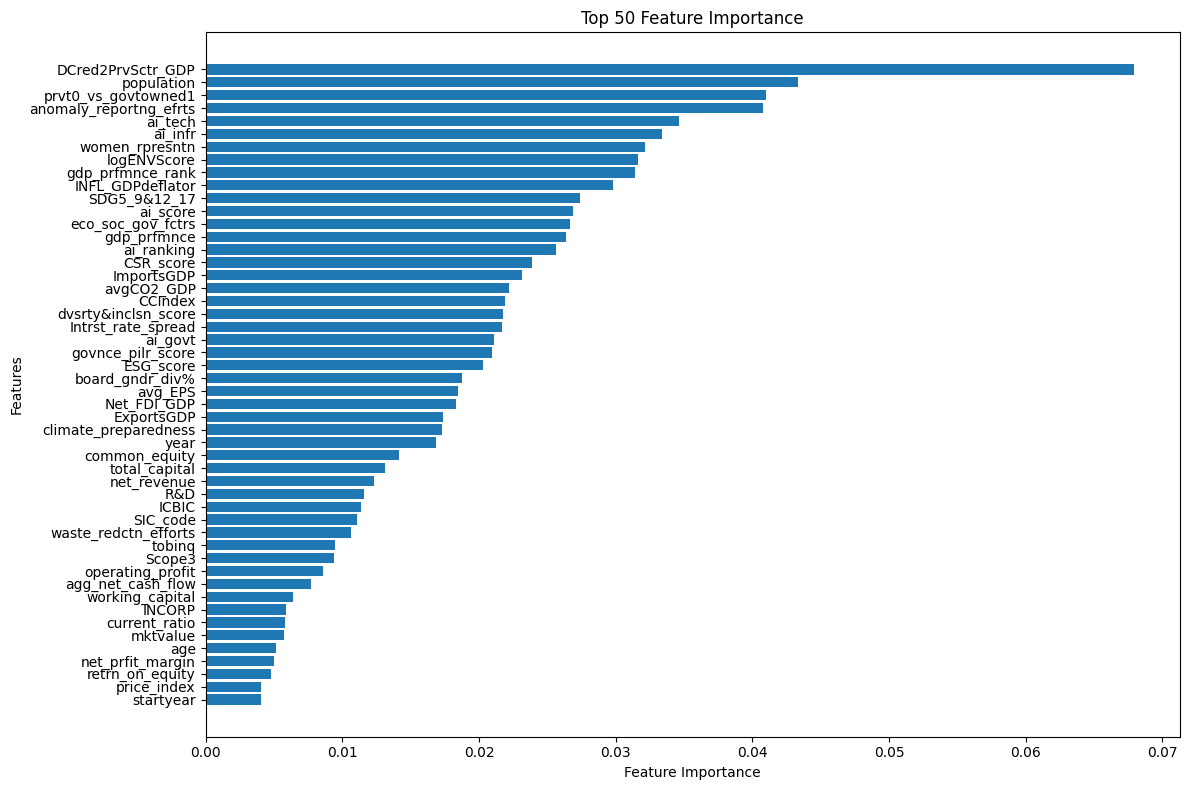

ValueError: matmul: Input operand 1 has a mismatch in its core dimension 0, with gufunc signature (n?,k),(k,m?)->(n?,m?) (size 1 is different from 56)

In [9]:
# 1. Reduce multicollinearity using VIF and PCA
def reduce_multicollinearity(X):
    # Calculate VIF
    vif = pd.DataFrame()
    vif["feature"] = X.columns
    vif["VIF"] = [variance_inflation_factor(X.values, i) for i in range(X.shape[1])]
    high_vif_features = vif[vif['VIF'] > 5]['feature'].tolist()

    # Apply PCA for features with high VIF
    pca = PCA(n_components=1)
    X_pca = X.copy()
    transformation_matrices = {}
    for feature in high_vif_features:
        feature_data = X[[feature]]
        pca.fit(feature_data)
        X_pca[feature] = pca.transform(feature_data)
        transformation_matrices[feature] = pca.components_

    return X_pca, transformation_matrices

# 2. Predict using SVR and XGB models
def predict_models(X_train, X_test, y_train, y_test):
    models = {'SVR': SVR(kernel='linear'), 'XGB': XGBRegressor()}
    results = {}

    for name, model in models.items():
        model.fit(X_train, y_train)
        y_pred_train = model.predict(X_train)
        y_pred_test = model.predict(X_test)

        results[name] = {
            'model': model,
            'train_pred': y_pred_train,
            'test_pred': y_pred_test,
            'train_R2': r2_score(y_train, y_pred_train),
            'test_R2': r2_score(y_test, y_pred_test),
            'train_MSE': mean_squared_error(y_train, y_pred_train),
            'test_MSE': mean_squared_error(y_test, y_pred_test),
            'train_RMSE': np.sqrt(mean_squared_error(y_train, y_pred_train)),
            'test_RMSE': np.sqrt(mean_squared_error(y_test, y_pred_test)),
            'train_MAE': mean_absolute_error(y_train, y_pred_train),
            'test_MAE': mean_absolute_error(y_test, y_pred_test)
        }
    return results

# Transform regression coefficients back to original variable space
def transform_coefficients(model, transformation_matrices, X_columns):
    original_coefficients = pd.Series(0, index=X_columns)
    for feature, matrix in transformation_matrices.items():
        original_coefficients[feature] = model.coef_ @ matrix.T
    return original_coefficients

# 3. Plot top 50 feature importance
def plot_top_features(model, X_train, filepath):
    feature_importances = model.feature_importances_
    top_indices = np.argsort(feature_importances)[::-1][:50]
    top_features = X_train.columns[top_indices]
    top_importances = feature_importances[top_indices]

    plt.figure(figsize=(12, 8))
    plt.barh(range(len(top_features)), top_importances, align='center')
    plt.yticks(range(len(top_features)), top_features)
    plt.xlabel('Feature Importance')
    plt.ylabel('Features')
    plt.title('Top 50 Feature Importance')
    plt.gca().invert_yaxis()
    plt.tight_layout()
    plt.savefig(filepath)
    plt.show()

# 4. Save top 50 feature importance
def save_top_features(model, X_train, filepath):
    feature_importances = model.feature_importances_
    top_indices = np.argsort(feature_importances)[::-1][:50]
    top_features = X_train.columns[top_indices]
    top_importances = feature_importances[top_indices]

    top_features_df = pd.DataFrame({'Feature': top_features, 'Importance': top_importances})
    top_features_df.to_csv(filepath, index=False)

# Load your data and perform preprocessing
# Assuming int_cols is the DataFrame with your data
scaler = StandardScaler()
int_cols_scaled = pd.DataFrame(scaler.fit_transform(int_cols), columns=int_cols.columns)

# Apply log transformation if necessary
target_col = 'total_emissns'
if np.abs(int_cols_scaled[target_col].skew()) > 0.5:
    int_cols_scaled[target_col] = np.log1p(int_cols_scaled[target_col])

# Split the data into features and target
X = int_cols_scaled.drop(columns=["total_emissns", "Emission_objtv", "emissn_score", "dirct_cemissions", "indirct_cemissions", "Grenhous_emissn", "CO2Emissn_%+-", "scope1", "scope2", "total_enrgy_use", "renwbl_enrgy_use", "envrmt_pilr_score", "Climate_incentive"])
y = int_cols_scaled["total_emissns"]

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

# Reduce multicollinearity
X_train_pca, transformation_matrices_train = reduce_multicollinearity(X_train)
X_test_pca, _ = reduce_multicollinearity(X_test)

# Predict using SVR and XGB models
results = predict_models(X_train_pca, X_test_pca, y_train, y_test)

# 5. Plot and save top 50 feature importance for XGB only
xgb_model = results['XGB']['model']
plot_top_features(xgb_model, X_train_pca, '/content/drive/My Drive/top50featXGB.png')
save_top_features(xgb_model, X_train_pca, '/content/drive/My Drive/top50featXGB.csv')

# Transform regression coefficients back to original variable space for SVR model
svr_model = results['SVR']['model']
svr_original_coefficients = transform_coefficients(svr_model, transformation_matrices_train, X_train.columns)
print("\nSVR Original Coefficients:\n", svr_original_coefficients)

# Print evaluation metrics
for name, result in results.items():
    print(f"{name} Model:")
    print("Train R2:", result['train_R2'])
    print("Train MSE:", result['train_MSE'])
    print("Train RMSE:", result['train_RMSE'])
    print("Train MAE:", result['train_MAE'])
    print("Test R2:", result['test_R2'])
    print("Test MSE:", result['test_MSE'])
    print("Test RMSE:", result['test_RMSE'])
    print("Test MAE:", result['test_MAE'])
    print()


In [ ]:
# 1. Reduce multicollinearity using VIF and PCA
def reduce_multicollinearity(X):
    # Calculate VIF
    vif = pd.DataFrame()
    vif["feature"] = X.columns
    vif["VIF"] = [variance_inflation_factor(X.values, i) for i in range(X.shape[1])]
    high_vif_features = vif[vif['VIF'] > 5]['feature'].tolist()

    # Apply PCA for features with high VIF
    pca = PCA(n_components=1)
    X_pca = X.copy()
    transformation_matrices = {}
    for feature in high_vif_features:
        feature_data = X[[feature]]
        pca.fit(feature_data)
        X_pca[feature] = pca.transform(feature_data)
        transformation_matrices[feature] = pca.components_

    return X_pca, transformation_matrices

# 2. Predict using SVR and XGB models
def predict_models(X_train, X_test, y_train, y_test):
    models = {'SVR': SVR(), 'XGB': XGBRegressor()}
    results = {}

    for name, model in models.items():
        model.fit(X_train, y_train)
        y_pred_train = model.predict(X_train)
        y_pred_test = model.predict(X_test)

        results[name] = {
            'model': model,
            'train_pred': y_pred_train,
            'test_pred': y_pred_test,
            'train_R2': r2_score(y_train, y_pred_train),
            'test_R2': r2_score(y_test, y_pred_test),
            'train_MSE': mean_squared_error(y_train, y_pred_train),
            'test_MSE': mean_squared_error(y_test, y_pred_test),
            'train_RMSE': np.sqrt(mean_squared_error(y_train, y_pred_train)),
            'test_RMSE': np.sqrt(mean_squared_error(y_test, y_pred_test)),
            'train_MAE': mean_absolute_error(y_train, y_pred_train),
            'test_MAE': mean_absolute_error(y_test, y_pred_test)
        }
    return results

# Transform regression coefficients back to original variable space
def transform_coefficients(model, transformation_matrices, X_columns):
    original_coefficients = pd.Series(0, index=X_columns)
    for feature, matrix in transformation_matrices.items():
        original_coefficients[feature] = model.coef_ @ matrix.T
    return original_coefficients

# 3. Plot top 50 feature importance
def plot_top_features(model, X_train, filepath):
    feature_importances = model.feature_importances_
    top_indices = np.argsort(feature_importances)[::-1][:50]
    top_features = X_train.columns[top_indices]
    top_importances = feature_importances[top_indices]

    plt.figure(figsize=(12, 8))
    plt.barh(range(len(top_features)), top_importances, align='center')
    plt.yticks(range(len(top_features)), top_features)
    plt.xlabel('Feature Importance')
    plt.ylabel('Features')
    plt.title('Top 50 Feature Importance')
    plt.gca().invert_yaxis()
    plt.tight_layout()
    plt.savefig(filepath)
    plt.show()

# 4. Save top 50 feature importance
def save_top_features(model, X_train, filepath):
    feature_importances = model.feature_importances_
    top_indices = np.argsort(feature_importances)[::-1][:50]
    top_features = X_train.columns[top_indices]
    top_importances = feature_importances[top_indices]

    top_features_df = pd.DataFrame({'Feature': top_features, 'Importance': top_importances})
    top_features_df.to_csv(filepath, index=False)

# Load your data and perform preprocessing
# Assuming int_cols is the DataFrame with your data
scaler = StandardScaler()
int_cols_scaled = pd.DataFrame(scaler.fit_transform(int_cols), columns=int_cols.columns)

# Apply log transformation if necessary
target_col = 'total_emissns'
if np.abs(int_cols_scaled[target_col].skew()) > 0.5:
    int_cols_scaled[target_col] = np.log1p(int_cols_scaled[target_col])

# Split the data into features and target
X = int_cols_scaled.drop(columns=["total_emissns", "Emission_objtv", "emissn_score", "dirct_cemissions", "indirct_cemissions", "Grenhous_emissn", "CO2Emissn_%+-", "scope1", "scope2", "total_enrgy_use", "renwbl_enrgy_use", "envrmt_pilr_score", "Climate_incentive"])
y = int_cols_scaled["total_emissns"]

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

# Reduce multicollinearity
X_train_pca, transformation_matrices_train = reduce_multicollinearity(X_train)
X_test_pca, _ = reduce_multicollinearity(X_test)

# Predict using SVR and XGB models
results = predict_models(X_train_pca, X_test_pca, y_train, y_test)

# 5. Plot and save top 50 feature importance for XGB only
xgb_model = results['XGB']['model']
plot_top_features(xgb_model, X_train_pca, '/content/drive/My Drive/top50featXGB.png')
save_top_features(xgb_model, X_train_pca, '/content/drive/My Drive/top50featXGB.csv')

# Transform regression coefficients back to original variable space for SVR model
svr_model = results['SVR']['model']
svr_original_coefficients = transform_coefficients(svr_model, transformation_matrices_train, X_train.columns)
print("\nSVR Original Coefficients:\n", svr_original_coefficients)

# Print evaluation metrics
for name, result in results.items():
    print(f"{name} Model:")
    print("Train R2:", result['train_R2'])
    print("Train MSE:", result['train_MSE'])
    print("Train RMSE:", result['train_RMSE'])
    print("Train MAE:", result['train_MAE'])
    print("Test R2:", result['test_R2'])
    print("Test MSE:", result['test_MSE'])
    print("Test RMSE:", result['test_RMSE'])
    print("Test MAE:", result['test_MAE'])
    print()


In [ ]:
# 1. Reduce multicollinearity using VIF and PCA
def reduce_multicollinearity(X):
    # Calculate VIF
    vif = pd.DataFrame()
    vif["feature"] = X.columns
    vif["VIF"] = [variance_inflation_factor(X.values, i) for i in range(X.shape[1])]
    high_vif_features = vif[vif['VIF'] > 5]['feature'].tolist()

    # Apply PCA for features with high VIF
    pca = PCA()
    X_pca = X.copy()
    for feature in high_vif_features:
        pca.fit(X[[feature]])
        X_pca[feature] = pca.transform(X[[feature]])

    return X_pca

# 2. Predict using SVR and XGB models
def predict_models(X_train, X_test, y_train, y_test):
    models = {'SVR': SVR(), 'XGB': XGBRegressor()}
    results = {}

    for name, model in models.items():
        model.fit(X_train, y_train)
        y_pred_train = model.predict(X_train)
        y_pred_test = model.predict(X_test)

        results[name] = {
            'model': model,
            'train_pred': y_pred_train,
            'test_pred': y_pred_test,
            'train_R2': r2_score(y_train, y_pred_train),
            'test_R2': r2_score(y_test, y_pred_test),
            'train_MSE': mean_squared_error(y_train, y_pred_train),
            'test_MSE': mean_squared_error(y_test, y_pred_test),
            'train_RMSE': np.sqrt(mean_squared_error(y_train, y_pred_train)),
            'test_RMSE': np.sqrt(mean_squared_error(y_test, y_pred_test)),
            'train_MAE': mean_absolute_error(y_train, y_pred_train),
            'test_MAE': mean_absolute_error(y_test, y_pred_test)
        }
    return results

# 3. Plot top 50 feature importance
def plot_top_features(model, X_train, filepath):
    feature_importances = model.feature_importances_
    top_indices = np.argsort(feature_importances)[::-1][:50]
    top_features = X_train.columns[top_indices]
    top_importances = feature_importances[top_indices]

    plt.figure(figsize=(12, 8))
    plt.barh(range(len(top_features)), top_importances, align='center')
    plt.yticks(range(len(top_features)), top_features)
    plt.xlabel('Feature Importance')
    plt.ylabel('Features')
    plt.title('Top 50 Feature Importance')
    plt.gca().invert_yaxis()
    plt.tight_layout()
    plt.savefig(filepath)
    plt.show()

# 4. Save top 50 feature importance
def save_top_features(model, X_train, filepath):
    feature_importances = model.feature_importances_
    top_indices = np.argsort(feature_importances)[::-1][:50]
    top_features = X_train.columns[top_indices]
    top_importances = feature_importances[top_indices]

    top_features_df = pd.DataFrame({'Feature': top_features, 'Importance': top_importances})
    top_features_df.to_csv(filepath, index=False)

# Load your data and perform preprocessing
scaler = StandardScaler()
int_cols_scaled = pd.DataFrame(scaler.fit_transform(int_cols), columns=int_cols.columns)

# Apply log transformation if necessary
target_col = 'total_emissns'
if np.abs(int_cols_scaled[target_col].skew()) > 0.5:
    int_cols_scaled[target_col] = np.log1p(int_cols_scaled[target_col])

# Split the data into features and target
X = int_cols_scaled.drop(columns=["total_emissns", "Emission_objtv", "emissn_score", "dirct_cemissions", "indirct_cemissions", "Grenhous_emissn", "CO2Emissn_%+-", "scope1", "scope2", "total_enrgy_use", "renwbl_enrgy_use", "envrmt_pilr_score", "Climate_incentive"])
y = int_cols_scaled["total_emissns"]

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

# Reduce multicollinearity
X_train_pca = reduce_multicollinearity(X_train)
X_test_pca = reduce_multicollinearity(X_test)

# Predict using SVR and XGB models
results = predict_models(X_train_pca, X_test_pca, y_train, y_test)

# 5. Plot and save top 50 feature importance for XGB only
xgb_model = results['XGB']['model']
plot_top_features(xgb_model, X_train_pca, '/content/drive/My Drive/top50featXGB.png')
save_top_features(xgb_model, X_train_pca, '/content/drive/My Drive/top50featXGB.csv')

# Print evaluation metrics
for name, result in results.items():
    print(f"{name} Model:")
    print("Train R2:", result['train_R2'])
    print("Train MSE:", result['train_MSE'])
    print("Train RMSE:", result['train_RMSE'])
    print("Train MAE:", result['train_MAE'])
    print("Test R2:", result['test_R2'])
    print("Test MSE:", result['test_MSE'])
    print("Test RMSE:", result['test_RMSE'])
    print("Test MAE:", result['test_MAE'])
    print()


In [ ]:

# Identify multicollinear variables
def calculate_vif(X):
    from statsmodels.stats.outliers_influence import variance_inflation_factor
    vif_data = pd.DataFrame()
    vif_data["feature"] = X.columns
    vif_data["VIF"] = [variance_inflation_factor(X.values, i) for i in range(len(X.columns))]
    return vif_data

vif_scores = calculate_vif(X_train)
high_vif_features = vif_scores[vif_scores['VIF'] > 5]['feature']

# Apply PCA to reduce multicollinearity for high VIF features
pca = PCA(n_components=0.95)  # Retain 95% variance
X_train_pca = pca.fit_transform(X_train[high_vif_features])
X_test_pca = pca.transform(X_test[high_vif_features])

# Train Support Vector Regression (SVR)
svr_model = SVR(kernel="linear")
svr_model.fit(X_train_pca, y_train)
svr_original_features = X_train[high_vif_features].columns[pca.components_]
component_indices = np.argsort(np.abs(pca.components_))[::-1][:len(svr_original_features)]
svr_coef_magnitudes = np.abs(svr_model.coef_)

# Train XGBoost model
xgb_model = xgb.XGBRegressor()
xgb_model.fit(X_train_pca, y_train)

svr_feature_importance = pd.DataFrame({'Feature': svr_original_features, 'Importance': svr_coef_magnitudes.flatten()})
svr_feature_importance = svr_feature_importance.sort_values(by='Importance', ascending=False).head(50)

# Feature importance for XGB
xgb_feature_importance = pd.DataFrame({'Feature': high_vif_features, 'Importance': xgb_model.feature_importances_})
xgb_feature_importance = xgb_feature_importance.sort_values(by='Importance', ascending=False).head(50)

# Evaluation metrics
def evaluate_model(model, X_train, X_test, y_train, y_test):
    train_pred = model.predict(X_train)
    test_pred = model.predict(X_test)
    train_r2 = r2_score(y_train, train_pred)
    test_r2 = r2_score(y_test, test_pred)
    train_mse = mean_squared_error(y_train, train_pred)
    test_mse = mean_squared_error(y_test, test_pred)
    train_rmse = np.sqrt(train_mse)
    test_rmse = np.sqrt(test_mse)
    train_mae = mean_absolute_error(y_train, train_pred)
    test_mae = mean_absolute_error(y_test, test_pred)
    return train_r2, test_r2, train_mse, test_mse, train_rmse, test_rmse, train_mae, test_mae

svr_metrics = evaluate_model(svr_model, X_train_pca, X_test_pca, y_train, y_test)
xgb_metrics = evaluate_model(xgb_model, X_train_pca, X_test_pca, y_train, y_test)

# Saving top 50 feature importance
svr_feature_importance.to_csv('/content/drive/My Drive/top50featSVR.csv', index=False)
xgb_feature_importance.to_csv('/content/drive/My Drive/top50featXGB.csv', index=False)

# Print evaluation metrics
print("SVR Model Metrics:")
print("Train R2:", svr_metrics[0])
print("Test R2:", svr_metrics[1])
print("Train MSE:", svr_metrics[2])
print("Test MSE:", svr_metrics[3])
print("Train RMSE:", svr_metrics[4])
print("Test RMSE:", svr_metrics[5])
print("Train MAE:", svr_metrics[6])
print("Test MAE:", svr_metrics[7])

print("\nXGB Model Metrics:")
print("Train R2:", xgb_metrics[0])
print("Test R2:", xgb_metrics[1])
print("Train MSE:", xgb_metrics[2])
print("Test MSE:", xgb_metrics[3])
print("Train RMSE:", xgb_metrics[4])
print("Test RMSE:", xgb_metrics[5])
print("Train MAE:", xgb_metrics[6])
print("Test MAE:", xgb_metrics[7])


In [ ]:
import pandas as pd
from sklearn.decomposition import PCA
from sklearn.pipeline import Pipeline
from xgboost import XGBRegressor
from sklearn.model_selection import RandomizedSearchCV, train_test_split

# Assume `int_cols_scaled` is the DataFrame after scaling and transformations
# Define the relevant columns with multicollinearity
cols_to_transform = ['ai_score', 'ai_govt', 'ai_tech', 'ai_infr', "net_revenue", "common_equity", "total_capital", "ImportsGDP", "ExportsGDP", ""]

# Extract the relevant columns for PCA
X_pca = int_cols_scaled[cols_to_transform]

# The rest of the features
X_other = int_cols_scaled.drop(columns=cols_to_transform)

# Define the model
xgb = XGBRegressor(objective='reg:squarederror', n_jobs=-1)

# Define a reduced parameter grid
param_grid_xgb = {
    'n_estimators': [50, 100],
    'max_depth': [3, 5],
    'learning_rate': [0.05, 0.1],
    'subsample': [0.8, 1.0],
    'colsample_bytree': [0.8, 1.0]
}

# Define the pipeline with PCA and the model
pipeline = Pipeline(steps=[
    ('pca', PCA(n_components=2)),
    ('xgb', xgb)
])

# Set up RandomizedSearchCV with fewer iterations and 3-fold CV
random_search_xgb = RandomizedSearchCV(pipeline, param_distributions={
    'xgb__n_estimators': param_grid_xgb['n_estimators'],
    'xgb__max_depth': param_grid_xgb['max_depth'],
    'xgb__learning_rate': param_grid_xgb['learning_rate'],
    'xgb__subsample': param_grid_xgb['subsample'],
    'xgb__colsample_bytree': param_grid_xgb['colsample_bytree']
}, n_iter=5, cv=3, scoring='r2', n_jobs=-1, random_state=42)

# Split the data into training and validation sets
X_train_sub, X_valid_sub, y_train_sub, y_valid_sub = train_test_split(X_train, y_train, test_size=0.2, random_state=42)

# Perform grid search with early stopping
random_search_xgb.fit(X_train_sub, y_train_sub,
                      eval_set=[(X_valid_sub, y_valid_sub)],
                      early_stopping_rounds=10,
                      verbose=False)

best_xgb = random_search_xgb.best_estimator_

# Extract feature importances from the XGBoost model within the pipeline
feature_importances = pd.DataFrame({
    'feature': list(X_other.columns) + ['pc1', 'pc2'],
    'importance': best_xgb.named_steps['xgb'].feature_importances_
}).sort_values(by='importance', ascending=False).head(50)

# Export the top 50 feature importances to a CSV file
feature_importances.to_csv('/mnt/data/top_50_feature_importances.csv', index=False)

# Also, exporting coefficients if needed (though not typical for tree-based models)
coefficients = best_xgb.named_steps['xgb'].get_booster().get_score(importance_type='weight')
coefficients_df = pd.DataFrame(list(coefficients.items()), columns=['feature', 'weight']).sort_values(by='weight', ascending=False).head(50)
coefficients_df.to_csv('/mnt/data/top_50_coefficients.csv', index=False)

# Print execution time for performance monitoring
import time
start_time = time.time()

# Place the main processing code here

end_time = time.time()
print(f"Grid search completed in {(end_time - start_time) / 60:.2f} minutes")


In [ ]:
#from sklearn.decomposition import PCA

#pca = PCA(n_components=0.95)  # Retain 95% of variance
#X_pca = pca.fit_transform(X)


In [ ]:
from sklearn.svm import SVR
from sklearn.model_selection import RandomizedSearchCV
from sklearn.inspection import permutation_importance
from scipy.stats import expon
import pandas as pd
import matplotlib.pyplot as plt

# Use an even smaller subset of the data
X_train_subset = X_train.sample(frac=0.1, random_state=42)
y_train_subset = y_train.sample(frac=0.1, random_state=42)

# Define the model
svr = SVR()

# Define the parameter distributions with fewer options
param_distributions_svr = {
    'kernel': ['linear', 'rbf'],
    'C': [0.1, 1, 10],  # Limited C values
    'epsilon': [0.01, 0.1]  # Limited epsilon values
}

# Perform randomized search with fewer iterations
random_search_svr = RandomizedSearchCV(svr, param_distributions_svr, n_iter=5, cv=3, scoring='r2', n_jobs=-1, random_state=42)  # Reduced n_iter to 5
random_search_svr.fit(X_train_subset, y_train_subset)

best_svr = random_search_svr.best_estimator_

# Print the best parameters and score
print("Best Parameters:", random_search_svr.best_params_)
print("Best Score:", random_search_svr.best_score_)

# Calculate permutation importances
result = permutation_importance(best_svr, X_train_subset, y_train_subset, n_repeats=10, random_state=42, n_jobs=-1)

# Create a DataFrame for feature importances
feature_importances = pd.DataFrame({
    'Feature': X_train_subset.columns,
    'Importance': result.importances_mean
})

# Select top 50 features
top_50_features = feature_importances.nlargest(50, 'Importance').reset_index(drop=True)

# Save the top 50 feature importances to a CSV file
top_50_features.to_csv('/content/drive/MyDrive/top_50_features_SVR.csv', index=False)

# Plot the top 50 feature importances
plt.figure(figsize=(10, 8))
plt.barh(range(50), top_50_features['Importance'], align='center', color=['blue' if x > 0 else 'red' for x in top_50_features['Importance']])
plt.yticks(range(50), top_50_features['Feature'])
plt.xlabel('Feature Importance')
plt.title('Top 50 Feature Importance for SVR')
plt.savefig('/content/drive/My Drive/top_50_plotSVR.png')
plt.show()


In [ ]:
from xgboost import XGBRegressor
from sklearn.model_selection import RandomizedSearchCV, train_test_split
import pandas as pd

# Define the model
xgb = XGBRegressor(objective='reg:squarederror', n_jobs=-1)

# Define a further reduced parameter grid
param_grid_xgb = {
    'n_estimators': [50, 100],
    'max_depth': [3, 5],
    'learning_rate': [0.05, 0.1],
    'subsample': [0.8, 1.0],
    'colsample_bytree': [0.8, 1.0]
}

# Set up RandomizedSearchCV with fewer iterations and 3-fold CV
random_search_xgb = RandomizedSearchCV(xgb, param_distributions=param_grid_xgb,
                                       n_iter=10, cv=3, scoring='r2', n_jobs=-1, random_state=42)

# Split the data to avoid overfitting on cross-validation during grid search
X_train_sub, X_valid_sub, y_train_sub, y_valid_sub = train_test_split(X_train, y_train, test_size=0.2, random_state=42)

# Perform grid search with early stopping
random_search_xgb.fit(X_train_sub, y_train_sub,
                      eval_set=[(X_valid_sub, y_valid_sub)],
                      early_stopping_rounds=10,
                      verbose=False)

best_xgb = random_search_xgb.best_estimator_

# Extract feature importances
feature_importances = pd.DataFrame({
    'feature': X_train.columns,
    'importance': best_xgb.feature_importances_
}).sort_values(by='importance', ascending=False).head(50)

# Export the top 50 feature importances to a CSV file
feature_importances.to_csv('/mnt/data/top_50_feature_importances.csv', index=False)

# Also, exporting coefficients if needed (though not typical for tree-based models)
coefficients = best_xgb.get_booster().get_score(importance_type='weight')
coefficients_df = pd.DataFrame(list(coefficients.items()), columns=['feature', 'weight']).sort_values(by='weight', ascending=False).head(50)
coefficients_df.to_csv('/mnt/data/top_50_coefficients.csv', index=False)



In [ ]:
importances = best_xgb.feature_importances_
indices = np.argsort(importances)[-50:]

plt.figure(figsize=(12, 8))
plt.title('Top 50 Feature Importance for XGBoost')
plt.barh(range(50), importances[indices], color=['blue' if i > 0 else 'red' for i in importances[indices]])
plt.yticks(range(50), [X.columns[i] for i in indices])
plt.xlabel('Feature Importance')
plt.savefig('/content/drive/My Drive/top_50_plotXGB.png')
plt.show()


In [ ]:
from sklearn.metrics import r2_score, mean_squared_error, mean_absolute_error
import numpy as np

def evaluate_model(model, X_train, y_train, X_test, y_test):
    y_train_pred = model.predict(X_train)
    y_test_pred = model.predict(X_test)

    metrics = {
        'R2 Train': r2_score(y_train, y_train_pred),
        'R2 Test': r2_score(y_test, y_test_pred),
        'MSE Train': mean_squared_error(y_train, y_train_pred),
        'MSE Test': mean_squared_error(y_test, y_test_pred),
        'RMSE Train': np.sqrt(mean_squared_error(y_train, y_train_pred)),
        'RMSE Test': np.sqrt(mean_squared_error(y_test, y_test_pred)),
        'MAE Train': mean_absolute_error(y_train, y_train_pred),
        'MAE Test': mean_absolute_error(y_test, y_test_pred)
    }

    return metrics

svr_metrics = evaluate_model(best_svr, X_train, y_train, X_test, y_test)
xgb_metrics = evaluate_model(best_xgb, X_train, y_train, X_test, y_test)

print('SVR Metrics:', svr_metrics)
print('XGB Metrics:', xgb_metrics)

# Save metrics to Google Drive
import json

with open('/content/drive/My Drive/svr_metrics.json', 'w') as f:
    json.dump(svr_metrics, f)

with open('/content/drive/My Drive/xgb_metrics.json', 'w') as f:
    json.dump(xgb_metrics, f)


In [ ]:
import pandas as pd

def actual_vs_predicted(model, X_test, y_test):
    y_pred = model.predict(X_test)
    comparison_df = pd.DataFrame({'Actual': y_test, 'Predicted': y_pred})
    return comparison_df

svr_comparison_df = actual_vs_predicted(best_svr, X_test, y_test)
xgb_comparison_df = actual_vs_predicted(best_xgb, X_test, y_test)

svr_comparison_df.to_csv('/content/drive/My Drive/svr_actual_vs_predicted.csv', index=False)
xgb_comparison_df.to_csv('/content/drive/My Drive/xgb_actual_vs_predicted.csv', index=False)
